## Extract tracer transports and save into files


This notebook extracts the tracer trabnsport through several cross sections along the shelf, across the shelf and vertically, from canyon to shelf. See plot below. Transport is divided in advective and diffusive by the model and stored in files called Flux01Glob.nc (01 is the tracer number for tracer 1).

Advective tracer transport $\Phi_{Tadv}=C\vec{u}\cdot\vec{a}$ 

Diffusive tracer transport $\Phi_{Tdiff}$, includes diffusion due to advection scheme)

| variable  | dims | units | description |
|:---------:|:---------:|:---------:|:---------:|
| UTRAC01   |   (T, Zmd000090, Y, Xp1) | Mol/L.m/s | Zonal Mass-Weighted Transp of Tr1 |
| VTRAC01   |   (T, Zmd000090, Yp1, X) | Mol/L.m/s | Meridional Mass-Weighted Transp of Tr1 |
| WTRAC01   |   (T, Zmd000090, Y, X)   | Mol/L.m/s | Vertical Mass-Weighted Transp of Tr1 |  
| ADVrTr01  |   (T, Zld000090, Y, X)   | Mol/L.m^3/s| Zonal Advective Flux of Tr1 |
| ADVxTr01  |   (T, Zmd000090, Y, Xp1) | Mol/L.m^3/s| Meridional Advective Flux of Tr1 |
| ADVyTr01  |   (T, Zmd000090, Yp1, X) | Mol/L.m^3/s| Vertical Advective Flux of Tr1 |
| DFrETr01  |   (T, Zld000090, Y, X)   | Mol/L.m^3/s| Vertical Diffusive Flux of Tr1 (Explicit part) |
| DFrITr01  |   (T, Zld000090, Y, X)   | Mol/L.m^3/s| Vertical Diffusive Flux of Tr1 (Implicit part) |
| DFxETr01  |   (T, Zmd000090, Y, Xp1) | Mol/L.m^3/s| Zonal Diffusive Flux of Tr1 |
| DFyETr01  |   (T, Zmd000090, Yp1, X) | Mol/L.m^3/s| Meridional Diffusive Flux of Tr1 |


* run##water_CS_transports.nc - cross-shelf and vertical transports
* run##water_ASupstm_transports.nc - alongshelf transports, upstream side of canyon
* run##water_ASdnstm_transports.nc - alongshelf transports, downstream side of canyon

There is one of each files for every run.

In [1]:
from math import *
from matplotlib.dates import num2date
import matplotlib.pyplot as plt
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io
import xarray as xr

In [2]:
# Define slices and positions of cross sections 
CS1_x_slice = slice(0, 59)
CS2_x_slice = slice(60, 119)
CS3_x_slice = slice(120, 239)
CS4_x_slice = slice(240, 299)
CS5_x_slice = slice(300, 359)

CS1_y_ind = 227

AS1_y_slice = slice(227, 266)
AS2_y_slice = slice(267, 298)
AS3_y_slice = slice(299, 359)


AS1_x_ind = 119
AS1b_x_ind = 239

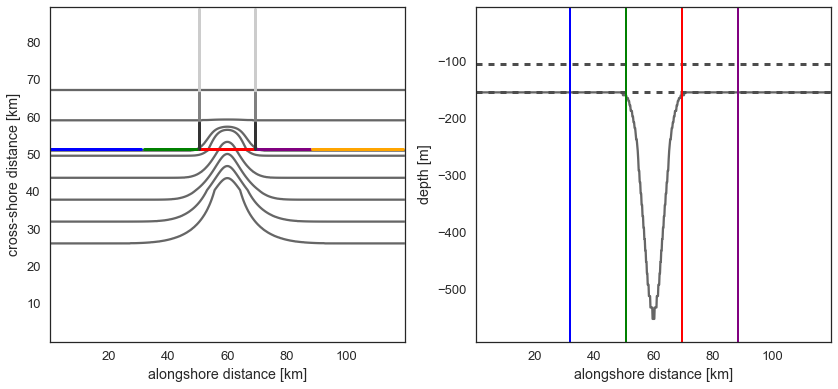

In [3]:
grid_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
grid = xr.open_dataset(grid_file)

sns.set_style(style='white')
sns.set_context('talk')
fig, ax = plt.subplots(1, 2, figsize=(14,6))

ax[0].contour(grid.X/1000,grid.Y/1000,grid.Depth,[50,100,150,200,400,600,800,1000], colors='0.4')

ax[0].plot(grid.XC[CS1_y_ind,CS1_x_slice]/1000,grid.YC[CS1_y_ind,CS1_x_slice]/1000, 'b-', linewidth=3)
ax[0].plot(grid.XC[CS1_y_ind,CS2_x_slice]/1000,grid.YC[CS1_y_ind,CS2_x_slice]/1000, 'g-', linewidth=3)
ax[0].plot(grid.XC[CS1_y_ind,CS3_x_slice]/1000,grid.YC[CS1_y_ind,CS3_x_slice]/1000, 'r-', linewidth=3)
ax[0].plot(grid.XC[CS1_y_ind,CS4_x_slice]/1000,grid.YC[CS1_y_ind,CS4_x_slice]/1000, '-',color='purple', linewidth=3)
ax[0].plot(grid.XC[CS1_y_ind,CS5_x_slice]/1000,grid.YC[CS1_y_ind,CS5_x_slice]/1000, '-', color='orange', linewidth=3)

ax[0].plot(grid.XC[AS1_y_slice,AS1_x_ind]/1000,grid.YC[AS1_y_slice,AS1_x_ind]/1000, '-', color='0.2',linewidth=3)
ax[0].plot(grid.XC[AS2_y_slice,AS1_x_ind]/1000,grid.YC[AS2_y_slice,AS1_x_ind]/1000, '-', color='0.5',linewidth=3)
ax[0].plot(grid.XC[AS3_y_slice,AS1_x_ind]/1000,grid.YC[AS3_y_slice,AS1_x_ind]/1000, '-', color='0.8',linewidth=3)

ax[0].plot(grid.XC[AS1_y_slice,AS1b_x_ind]/1000,grid.YC[AS1_y_slice,AS1b_x_ind]/1000, '-', color='0.2', linewidth=3)
ax[0].plot(grid.XC[AS2_y_slice,AS1b_x_ind]/1000,grid.YC[AS2_y_slice,AS1b_x_ind]/1000, '-', color='0.5', linewidth=3)
ax[0].plot(grid.XC[AS3_y_slice,AS1b_x_ind]/1000,grid.YC[AS3_y_slice,AS1b_x_ind]/1000, '-', color='0.8', linewidth=3)

ax[0].set_xlabel('alongshore distance [km]')
ax[0].set_ylabel('cross-shore distance [km]')

ax[1].contour(grid.XC[227,:]/1000,grid.RC[:60],grid.HFacC[:60,227,:],[0],colors='0.4')
ax[1].plot([grid.X[0]/1000,grid.X[359]/1000],[grid.RC[20],grid.RC[20]], '--', color='0.3', linewidth=3)
ax[1].plot([grid.X[0]/1000,grid.X[359]/1000],[grid.RC[30],grid.RC[30]], '--', color='0.3', linewidth=3)

ax[1].axvline(x=grid.X[60]/1000,color='b', linewidth=2)
ax[1].axvline(x=grid.X[120]/1000,color='g', linewidth=2)
ax[1].axvline(x=grid.X[240]/1000,color='r', linewidth=2)
ax[1].axvline(x=grid.X[300]/1000,color='purple', linewidth=2)


ax[1].set_xlabel('alongshore distance [km]')
ax[1].set_ylabel('depth [m]')


In [4]:
def calc_trac_transport_CS(flux_component, x_slice, y_slice, dim_name,zini=0,zfin=90):
    '''
    INPUT:
    flux_component: xarray, flux component perpendicular to cross section (e.g. unstagger_xarray(flux38.V,'Yp1'))
    x_slice : slice or index of cross-section in alongshore direction
    y_slice : slice or index of cross-section in cross-shore direction
    dim_name: str, name of the dimension along which to sum.
    
    '''
    return (((flux_component.isel(Yp1=y_slice, X=x_slice)).sum(dim=dim_name)).isel(
            Zmd000090=slice(zini,zfin))).sum(dim='Zmd000090')

def calc_trac_transport_AS(flux_component, x_slice, y_slice, dim_name,zini=0,zfin=90):
    '''
    INPUT:
    flux_component: xarray, Flux component perpendicular to cross section (e.g. unstagger_xarray(flux38.V,'Yp1'))
    x_slice : slice or index of cross-section in alongshore direction
    y_slice : slice or index of cross-section in cross-shore direction
    dim_name: str, name of the dimension along which to sum.
    
    '''
    return (((flux_component.isel(Y=y_slice, Xp1=x_slice)).sum(dim=dim_name)).isel(
            Zmd000090=slice(zini,zfin))).sum(dim='Zmd000090')
   

def unstagger_xarray(qty, index):
    """Interpolate u, v, or w component values to values at grid cell centres.
    
    Named indexing requires that input arrays are XArray DataArrays.

    :arg qty: u, v, or w component values
    :type qty: :py:class:`xarray.DataArray`
    
    :arg index: index name along which to centre
        (generally one of 'gridX', 'gridY', or 'depth')
    :type index: str

    :returns qty: u, v, or w component values at grid cell centres
    :rtype: :py:class:`xarray.DataArray`
    """
    
    qty = (qty + qty.shift(**{index: 1})) / 2
    
    return qty

def fig_looks(ax, title = 'Cross-shelf transport'):
    '''define aesthetics of transport plots'''
    sns.set_style(style='whitegrid')
    sns.set_context('talk')

    ax.set_ylabel('tracer transport [$Mol/l.m^3s^{-1}$]')
    ax.set_xlabel('Time [$s$]')
    ax.legend(loc=0)
    ax.set_title(title)
    
    return(ax)

In [5]:
#set up paths and files
grid_Can_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/gridGlob.nc'
grid_NoC_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run07/gridGlob.nc'

path_CNT = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/'
path_DIFF3D = '/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/'

CNTruns = ['run03',
           'run11',
           'run12',
           'run14',
           'run15',
           'run16',
           'run17',
           'run18',
           'run19',
]

tracer_nums = ['01',
                '02',
                '03',
                '01',
                '01',
                '01',
                '03',
                '01',
                '01',
]  


CNTrunsNoC = ['run07',
              'run24',
              'run25',
              'run26',
              'run27',
              'run28',
              'run30',
              'run22',
              'run23',
]

DIFF3Druns = ['run04',
              'run05',
              'run06',
              'run07',
]



### CNT runs

In [13]:
# CNT runs, this should be a function!

grid = xr.open_dataset(grid_Can_file)
path_run = path_CNT

ii = 0

for run,TrNum in zip(CNTruns,tracer_nums):
    file_path = path_run+run+'/FluxTR'+TrNum+'Glob.nc'
    flux = xr.open_dataset(file_path)
    
    if TrNum == '02':
        advCS1_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr02,'Yp1'), CS1_x_slice, CS1_y_ind, 'X')
        advCS2_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr02,'Yp1'), CS2_x_slice, CS1_y_ind, 'X')
        advCS3_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr02,'Yp1'), CS3_x_slice, CS1_y_ind, 'X')
        advCS4_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr02,'Yp1'), CS4_x_slice, CS1_y_ind, 'X')
        advCS5_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr02,'Yp1'), CS5_x_slice, CS1_y_ind, 'X')

        advCS1_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr02,'Yp1'), CS1_x_slice, CS1_y_ind, 'X',0,20)
        advCS2_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr02,'Yp1'), CS2_x_slice, CS1_y_ind, 'X',0,20)
        advCS3_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr02,'Yp1'), CS3_x_slice, CS1_y_ind, 'X',0,20)
        advCS4_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr02,'Yp1'), CS4_x_slice, CS1_y_ind, 'X',0,20)
        advCS5_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr02,'Yp1'), CS5_x_slice, CS1_y_ind, 'X',0,20)

        advCS1_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr02,'Yp1'), CS1_x_slice, CS1_y_ind, 'X',20,30)
        advCS2_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr02,'Yp1'), CS2_x_slice, CS1_y_ind, 'X',20,30)
        advCS3_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr02,'Yp1'), CS3_x_slice, CS1_y_ind, 'X',20,30)
        advCS4_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr02,'Yp1'), CS4_x_slice, CS1_y_ind, 'X',20,30)
        advCS5_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr02,'Yp1'), CS5_x_slice, CS1_y_ind, 'X',20,30)


        advCS3_flux_152_to_bott = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr02,'Yp1'), CS3_x_slice, CS1_y_ind, 'X',30,90)


        advAS1_flux = calc_trac_transport_AS(unstagger_xarray(flux.ADVxTr02,'Xp1'), AS1_x_ind, AS1_y_slice,'Y')
        advAS2_flux = calc_trac_transport_AS(unstagger_xarray(flux.ADVxTr02,'Xp1'), AS1_x_ind, AS2_y_slice,'Y')
        advAS3_flux = calc_trac_transport_AS(unstagger_xarray(flux.ADVxTr02,'Xp1'), AS1_x_ind, AS3_y_slice,'Y')


        advAS1b_flux = calc_trac_transport_AS(unstagger_xarray(flux.ADVxTr02,'Xp1'), AS1b_x_ind, AS1_y_slice,'Y')
        advAS2b_flux = calc_trac_transport_AS(unstagger_xarray(flux.ADVxTr02,'Xp1'), AS1b_x_ind, AS2_y_slice,'Y')
        advAS3b_flux = calc_trac_transport_AS(unstagger_xarray(flux.ADVxTr02,'Xp1'), AS1b_x_ind, AS3_y_slice,'Y')


        vel_vert = (unstagger_xarray(flux.ADVrTr02,'Zld000090').isel(Zld000090=30,Y=slice(227,267), X=slice(120,240)))
        advVert_flux = (vel_vert).sum(dim='Y').sum(dim='X')
    
    elif TrNum == '03':
        advCS1_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr03,'Yp1'), CS1_x_slice, CS1_y_ind, 'X')
        advCS2_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr03,'Yp1'), CS2_x_slice, CS1_y_ind, 'X')
        advCS3_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr03,'Yp1'), CS3_x_slice, CS1_y_ind, 'X')
        advCS4_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr03,'Yp1'), CS4_x_slice, CS1_y_ind, 'X')
        advCS5_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr03,'Yp1'), CS5_x_slice, CS1_y_ind, 'X')

        advCS1_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr03,'Yp1'), CS1_x_slice, CS1_y_ind, 'X',0,20)
        advCS2_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr03,'Yp1'), CS2_x_slice, CS1_y_ind, 'X',0,20)
        advCS3_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr03,'Yp1'), CS3_x_slice, CS1_y_ind, 'X',0,20)
        advCS4_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr03,'Yp1'), CS4_x_slice, CS1_y_ind, 'X',0,20)
        advCS5_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr03,'Yp1'), CS5_x_slice, CS1_y_ind, 'X',0,20)

        advCS1_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr03,'Yp1'), CS1_x_slice, CS1_y_ind, 'X',20,30)
        advCS2_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr03,'Yp1'), CS2_x_slice, CS1_y_ind, 'X',20,30)
        advCS3_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr03,'Yp1'), CS3_x_slice, CS1_y_ind, 'X',20,30)
        advCS4_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr03,'Yp1'), CS4_x_slice, CS1_y_ind, 'X',20,30)
        advCS5_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr03,'Yp1'), CS5_x_slice, CS1_y_ind, 'X',20,30)

        advCS3_flux_152_to_bott = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr03,'Yp1'), CS3_x_slice, CS1_y_ind, 'X',30,90)

        advAS1_flux = calc_trac_transport_AS(unstagger_xarray(flux.ADVxTr03,'Xp1'), AS1_x_ind, AS1_y_slice,'Y')
        advAS2_flux = calc_trac_transport_AS(unstagger_xarray(flux.ADVxTr03,'Xp1'), AS1_x_ind, AS2_y_slice,'Y')
        advAS3_flux = calc_trac_transport_AS(unstagger_xarray(flux.ADVxTr03,'Xp1'), AS1_x_ind, AS3_y_slice,'Y')

        advAS1b_flux = calc_trac_transport_AS(unstagger_xarray(flux.ADVxTr03,'Xp1'), AS1b_x_ind, AS1_y_slice,'Y')
        advAS2b_flux = calc_trac_transport_AS(unstagger_xarray(flux.ADVxTr03,'Xp1'), AS1b_x_ind, AS2_y_slice,'Y')
        advAS3b_flux = calc_trac_transport_AS(unstagger_xarray(flux.ADVxTr03,'Xp1'), AS1b_x_ind, AS3_y_slice,'Y')

        vel_vert = (unstagger_xarray(flux.ADVrTr03,'Zld000090').isel(Zld000090=30,Y=slice(227,267), X=slice(120,240)))
        advVert_flux = (vel_vert).sum(dim='Y').sum(dim='X')
    
    else:
    
        advCS1_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X')
        advCS2_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X')
        advCS3_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X')
        advCS4_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X')
        advCS5_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X')

        advCS1_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X',0,20)
        advCS2_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X',0,20)
        advCS3_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X',0,20)
        advCS4_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X',0,20)
        advCS5_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X',0,20)

        advCS1_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X',20,30)
        advCS2_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X',20,30)
        advCS3_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X',20,30)
        advCS4_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X',20,30)
        advCS5_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X',20,30)


        advCS3_flux_152_to_bott = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X',30,90)


        advAS1_flux = calc_trac_transport_AS(unstagger_xarray(flux.ADVxTr01,'Xp1'), AS1_x_ind, AS1_y_slice,'Y')
        advAS2_flux = calc_trac_transport_AS(unstagger_xarray(flux.ADVxTr01,'Xp1'), AS1_x_ind, AS2_y_slice,'Y')
        advAS3_flux = calc_trac_transport_AS(unstagger_xarray(flux.ADVxTr01,'Xp1'), AS1_x_ind, AS3_y_slice,'Y')


        advAS1b_flux = calc_trac_transport_AS(unstagger_xarray(flux.ADVxTr01,'Xp1'), AS1b_x_ind, AS1_y_slice,'Y')
        advAS2b_flux = calc_trac_transport_AS(unstagger_xarray(flux.ADVxTr01,'Xp1'), AS1b_x_ind, AS2_y_slice,'Y')
        advAS3b_flux = calc_trac_transport_AS(unstagger_xarray(flux.ADVxTr01,'Xp1'), AS1b_x_ind, AS3_y_slice,'Y')


        vel_vert = (unstagger_xarray(flux.ADVrTr01,'Zld000090').isel(Zld000090=30,Y=slice(227,267), X=slice(120,240)))
        advVert_flux = (vel_vert).sum(dim='Y').sum(dim='X')
    
    
    advVert_flux.name = 'Vert_adv_trans_sb'
    advVert_flux.attrs['units'] = 'm3/s'

    advCS1_flux.name = 'CS1_adv_trans'
    advCS1_flux.attrs['units'] = 'm3/s'
    advCS2_flux.name = 'CS2_adv_trans'
    advCS2_flux.attrs['units'] = 'm3/s'
    advCS3_flux.name = 'CS3_adv_trans'
    advCS3_flux.attrs['units'] = 'm3/s'
    advCS4_flux.name = 'CS4_adv_trans'
    advCS4_flux.attrs['units'] = 'm3/s'
    advCS5_flux.name = 'CS5_adv_trans'
    advCS5_flux.attrs['units'] = 'm3/s'
   
    advCS1_flux_0_to_100.name = 'CS1_adv_trans_0_to_100'
    advCS1_flux_0_to_100.attrs['units'] = 'm3/s'
    advCS2_flux_0_to_100.name = 'CS2_adv_trans_0_to_100'
    advCS2_flux_0_to_100.attrs['units'] = 'm3/s'
    advCS3_flux_0_to_100.name = 'CS3_adv_trans_0_to_100'
    advCS3_flux_0_to_100.attrs['units'] = 'm3/s'
    advCS4_flux_0_to_100.name = 'CS4_adv_trans_0_to_100'
    advCS4_flux_0_to_100.attrs['units'] = 'm3/s'
    advCS5_flux_0_to_100.name = 'CS5_adv_trans_0_to_100'
    advCS5_flux_0_to_100.attrs['units'] = 'm3/s'
    
    advCS1_flux_100_to_152.name = 'CS1_adv_trans_100_to_152'
    advCS1_flux_100_to_152.attrs['units'] = 'm3/s'
    advCS2_flux_100_to_152.name = 'CS2_adv_trans_100_to_152'
    advCS2_flux_100_to_152.attrs['units'] = 'm3/s'
    advCS3_flux_100_to_152.name = 'CS3_adv_trans_100_to_152'
    advCS3_flux_100_to_152.attrs['units'] = 'm3/s'
    advCS4_flux_100_to_152.name = 'CS4_adv_trans_100_to_152'
    advCS4_flux_100_to_152.attrs['units'] = 'm3/s'
    advCS5_flux_100_to_152.name = 'CS5_adv_trans_100_to_152'
    advCS5_flux_100_to_152.attrs['units'] = 'm3/s'

    advCS3_flux_152_to_bott.name = 'CS3_adv_trans_152_to_bot'
    advCS3_flux_152_to_bott.attrs['units'] = 'm3/s'
    
    advAS1_flux.name = 'AS1_adv_trans_upstm'
    advAS1_flux.attrs['units'] = 'm3/s'
    advAS2_flux.name = 'AS2_adv_trans_upstm'
    advAS2_flux.attrs['units'] = 'm3/s'
    advAS3_flux.name = 'AS3_adv_trans_upstm'
    advAS3_flux.attrs['units'] = 'm3/s'

    advAS1b_flux.name = 'AS1_adv_trans_dnstm'
    advAS1b_flux.attrs['units'] = 'm3/s'
    advAS2b_flux.name = 'AS2_adv_trans_dnstm'
    advAS2b_flux.attrs['units'] = 'm3/s'
    advAS3b_flux.name = 'AS3_adv_trans_dnstm'
    advAS3b_flux.attrs['units'] = 'm3/s'
    
    objectsCS = [advCS1_flux, advCS2_flux,advCS3_flux,advCS4_flux,advCS5_flux,
                 advCS1_flux_0_to_100, advCS2_flux_0_to_100,advCS3_flux_0_to_100,advCS4_flux_0_to_100,
                 advCS5_flux_0_to_100,
                 advCS1_flux_100_to_152, advCS2_flux_100_to_152,advCS3_flux_100_to_152,advCS4_flux_100_to_152,
                 advCS5_flux_100_to_152,
                 advCS3_flux_152_to_bott,advVert_flux]
               
    objectsASups = [advAS1_flux,advAS2_flux,advAS3_flux]
                 
    objectsASdns = [advAS1b_flux,advAS2b_flux,advAS3b_flux]
    
    DS_CS = xr.merge(objectsCS, compat='broadcast_equals', join='outer')
    DS_CS_path = path_run+run+'adv_CS_transports.nc'
    DS_CS.to_netcdf(path=DS_CS_path, mode='w', format='NETCDF4')
    
    DS_ASups = xr.merge(objectsASups, compat='broadcast_equals', join='outer')
    DS_ASups_path = path_run+run+'adv_ASupstm_transports.nc'
    DS_ASups.to_netcdf(path=DS_ASups_path, mode='w', format='NETCDF4')

    DS_ASdns = xr.merge(objectsASdns, compat='broadcast_equals', join='outer')
    DS_ASdns_path = path_run+run+'adv_ASdnstm_transports.nc'
    DS_ASdns.to_netcdf(path=DS_ASdns_path, mode='w', format='NETCDF4')
   
    print(DS_CS_path)
    ii=ii+1
    



/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03adv_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run11adv_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run12adv_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run14adv_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run15adv_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run16adv_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run17adv_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run18adv_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run19adv_CS_transports.nc


In [14]:
# CNT runs, this should be a function!

grid = xr.open_dataset(grid_Can_file)
path_run = path_CNT

ii = 0

for run,TrNum in zip(CNTruns,tracer_nums):
    file_path = path_run+run+'/FluxTR'+TrNum+'Glob.nc'
    flux = xr.open_dataset(file_path)
    
    if TrNum == '02':
        
        diffCS1_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr02,'Yp1'), CS1_x_slice, CS1_y_ind, 'X')
        diffCS2_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr02,'Yp1'), CS2_x_slice, CS1_y_ind, 'X')
        diffCS3_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr02,'Yp1'), CS3_x_slice, CS1_y_ind, 'X')
        diffCS4_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr02,'Yp1'), CS4_x_slice, CS1_y_ind, 'X')
        diffCS5_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr02,'Yp1'), CS5_x_slice, CS1_y_ind, 'X')

        diffCS1_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr02,'Yp1'), CS1_x_slice, CS1_y_ind, 'X',0,20)
        diffCS2_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr02,'Yp1'), CS2_x_slice, CS1_y_ind, 'X',0,20)
        diffCS3_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr02,'Yp1'), CS3_x_slice, CS1_y_ind, 'X',0,20)
        diffCS4_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr02,'Yp1'), CS4_x_slice, CS1_y_ind, 'X',0,20)
        diffCS5_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr02,'Yp1'), CS5_x_slice, CS1_y_ind, 'X',0,20)

        diffCS1_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr02,'Yp1'), CS1_x_slice, CS1_y_ind, 'X',20,30)
        diffCS2_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr02,'Yp1'), CS2_x_slice, CS1_y_ind, 'X',20,30)
        diffCS3_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr02,'Yp1'), CS3_x_slice, CS1_y_ind, 'X',20,30)
        diffCS4_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr02,'Yp1'), CS4_x_slice, CS1_y_ind, 'X',20,30)
        diffCS5_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr02,'Yp1'), CS5_x_slice, CS1_y_ind, 'X',20,30)

        diffCS3_flux_152_to_bott = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr02,'Yp1'), CS3_x_slice, CS1_y_ind, 'X',30,90)

        diffAS1_flux = calc_trac_transport_AS(unstagger_xarray(flux.DFxETr02,'Xp1'), AS1_x_ind, AS1_y_slice,'Y')
        diffAS2_flux = calc_trac_transport_AS(unstagger_xarray(flux.DFxETr02,'Xp1'), AS1_x_ind, AS2_y_slice,'Y')
        diffAS3_flux = calc_trac_transport_AS(unstagger_xarray(flux.DFxETr02,'Xp1'), AS1_x_ind, AS3_y_slice,'Y')

        diffAS1b_flux = calc_trac_transport_AS(unstagger_xarray(flux.DFxETr02,'Xp1'), AS1b_x_ind, AS1_y_slice,'Y')
        diffAS2b_flux = calc_trac_transport_AS(unstagger_xarray(flux.DFxETr02,'Xp1'), AS1b_x_ind, AS2_y_slice,'Y')
        diffAS3b_flux = calc_trac_transport_AS(unstagger_xarray(flux.DFxETr02,'Xp1'), AS1b_x_ind, AS3_y_slice,'Y')

        vert_E = (unstagger_xarray(flux.DFrETr02,'Zld000090').isel(Zld000090=30,Y=slice(227,267), X=slice(120,240)))
        vert_I = (unstagger_xarray(flux.DFrITr02,'Zld000090').isel(Zld000090=30,Y=slice(227,267), X=slice(120,240)))

        diffVert_fluxE = (vert_E).sum(dim='Y').sum(dim='X')
        diffVert_fluxI = (vert_I).sum(dim='Y').sum(dim='X')
    
    elif TrNum == '03':
        
        diffCS1_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr03,'Yp1'), CS1_x_slice, CS1_y_ind, 'X')
        diffCS2_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr03,'Yp1'), CS2_x_slice, CS1_y_ind, 'X')
        diffCS3_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr03,'Yp1'), CS3_x_slice, CS1_y_ind, 'X')
        diffCS4_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr03,'Yp1'), CS4_x_slice, CS1_y_ind, 'X')
        diffCS5_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr03,'Yp1'), CS5_x_slice, CS1_y_ind, 'X')

        diffCS1_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr03,'Yp1'), CS1_x_slice, CS1_y_ind, 'X',0,20)
        diffCS2_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr03,'Yp1'), CS2_x_slice, CS1_y_ind, 'X',0,20)
        diffCS3_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr03,'Yp1'), CS3_x_slice, CS1_y_ind, 'X',0,20)
        diffCS4_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr03,'Yp1'), CS4_x_slice, CS1_y_ind, 'X',0,20)
        diffCS5_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr03,'Yp1'), CS5_x_slice, CS1_y_ind, 'X',0,20)

        diffCS1_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr03,'Yp1'), CS1_x_slice, CS1_y_ind, 'X',20,30)
        diffCS2_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr03,'Yp1'), CS2_x_slice, CS1_y_ind, 'X',20,30)
        diffCS3_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr03,'Yp1'), CS3_x_slice, CS1_y_ind, 'X',20,30)
        diffCS4_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr03,'Yp1'), CS4_x_slice, CS1_y_ind, 'X',20,30)
        diffCS5_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr03,'Yp1'), CS5_x_slice, CS1_y_ind, 'X',20,30)

        diffCS3_flux_152_to_bott = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr03,'Yp1'), CS3_x_slice, CS1_y_ind, 'X',30,90)

        diffAS1_flux = calc_trac_transport_AS(unstagger_xarray(flux.DFxETr03,'Xp1'), AS1_x_ind, AS1_y_slice,'Y')
        diffAS2_flux = calc_trac_transport_AS(unstagger_xarray(flux.DFxETr03,'Xp1'), AS1_x_ind, AS2_y_slice,'Y')
        diffAS3_flux = calc_trac_transport_AS(unstagger_xarray(flux.DFxETr03,'Xp1'), AS1_x_ind, AS3_y_slice,'Y')

        diffAS1b_flux = calc_trac_transport_AS(unstagger_xarray(flux.DFxETr03,'Xp1'), AS1b_x_ind, AS1_y_slice,'Y')
        diffAS2b_flux = calc_trac_transport_AS(unstagger_xarray(flux.DFxETr03,'Xp1'), AS1b_x_ind, AS2_y_slice,'Y')
        diffAS3b_flux = calc_trac_transport_AS(unstagger_xarray(flux.DFxETr03,'Xp1'), AS1b_x_ind, AS3_y_slice,'Y')

        vert_E = (unstagger_xarray(flux.DFrETr03,'Zld000090').isel(Zld000090=30,Y=slice(227,267), X=slice(120,240)))
        vert_I = (unstagger_xarray(flux.DFrITr03,'Zld000090').isel(Zld000090=30,Y=slice(227,267), X=slice(120,240)))

        diffVert_fluxE = (vert_E).sum(dim='Y').sum(dim='X')
        diffVert_fluxI = (vert_I).sum(dim='Y').sum(dim='X')
    
    else:
        diffCS1_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X')
        diffCS2_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X')
        diffCS3_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X')
        diffCS4_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X')
        diffCS5_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X')

        diffCS1_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X',0,20)
        diffCS2_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X',0,20)
        diffCS3_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X',0,20)
        diffCS4_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X',0,20)
        diffCS5_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X',0,20)

        diffCS1_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X',20,30)
        diffCS2_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X',20,30)
        diffCS3_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X',20,30)
        diffCS4_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X',20,30)
        diffCS5_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X',20,30)

        diffCS3_flux_152_to_bott = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X',30,90)

        diffAS1_flux = calc_trac_transport_AS(unstagger_xarray(flux.DFxETr01,'Xp1'), AS1_x_ind, AS1_y_slice,'Y')
        diffAS2_flux = calc_trac_transport_AS(unstagger_xarray(flux.DFxETr01,'Xp1'), AS1_x_ind, AS2_y_slice,'Y')
        diffAS3_flux = calc_trac_transport_AS(unstagger_xarray(flux.DFxETr01,'Xp1'), AS1_x_ind, AS3_y_slice,'Y')

        diffAS1b_flux = calc_trac_transport_AS(unstagger_xarray(flux.DFxETr01,'Xp1'), AS1b_x_ind, AS1_y_slice,'Y')
        diffAS2b_flux = calc_trac_transport_AS(unstagger_xarray(flux.DFxETr01,'Xp1'), AS1b_x_ind, AS2_y_slice,'Y')
        diffAS3b_flux = calc_trac_transport_AS(unstagger_xarray(flux.DFxETr01,'Xp1'), AS1b_x_ind, AS3_y_slice,'Y')

        vert_E = (unstagger_xarray(flux.DFrETr01,'Zld000090').isel(Zld000090=30,Y=slice(227,267), X=slice(120,240)))
        vert_I = (unstagger_xarray(flux.DFrITr01,'Zld000090').isel(Zld000090=30,Y=slice(227,267), X=slice(120,240)))

        diffVert_fluxE = (vert_E).sum(dim='Y').sum(dim='X')
        diffVert_fluxI = (vert_I).sum(dim='Y').sum(dim='X')
    
    diffVert_fluxE.name = 'Vert_exp_diff_trans_sb'
    diffVert_fluxE.attrs['units'] = 'm3/s'
    diffVert_fluxI.name = 'Vert_imp_diff_trans_sb'
    diffVert_fluxI.attrs['units'] = 'm3/s'

    diffCS1_flux.name = 'CS1_diff_trans'
    diffCS1_flux.attrs['units'] = 'm3/s'
    diffCS2_flux.name = 'CS2_diff_trans'
    diffCS2_flux.attrs['units'] = 'm3/s'
    diffCS3_flux.name = 'CS3_diff_trans'
    diffCS3_flux.attrs['units'] = 'm3/s'
    diffCS4_flux.name = 'CS4_diff_trans'
    diffCS4_flux.attrs['units'] = 'm3/s'
    diffCS5_flux.name = 'CS5_diff_trans'
    diffCS5_flux.attrs['units'] = 'm3/s'
   
    diffCS1_flux_0_to_100.name = 'CS1_diff_trans_0_to_100'
    diffCS1_flux_0_to_100.attrs['units'] = 'm3/s'
    diffCS2_flux_0_to_100.name = 'CS2_diff_trans_0_to_100'
    diffCS2_flux_0_to_100.attrs['units'] = 'm3/s'
    diffCS3_flux_0_to_100.name = 'CS3_diff_trans_0_to_100'
    diffCS3_flux_0_to_100.attrs['units'] = 'm3/s'
    diffCS4_flux_0_to_100.name = 'CS4_diff_trans_0_to_100'
    diffCS4_flux_0_to_100.attrs['units'] = 'm3/s'
    diffCS5_flux_0_to_100.name = 'CS5_diff_trans_0_to_100'
    diffCS5_flux_0_to_100.attrs['units'] = 'm3/s'
    
    diffCS1_flux_100_to_152.name = 'CS1_diff_trans_100_to_152'
    diffCS1_flux_100_to_152.attrs['units'] = 'm3/s'
    diffCS2_flux_100_to_152.name = 'CS2_diff_trans_100_to_152'
    diffCS2_flux_100_to_152.attrs['units'] = 'm3/s'
    diffCS3_flux_100_to_152.name = 'CS3_diff_trans_100_to_152'
    diffCS3_flux_100_to_152.attrs['units'] = 'm3/s'
    diffCS4_flux_100_to_152.name = 'CS4_diff_trans_100_to_152'
    diffCS4_flux_100_to_152.attrs['units'] = 'm3/s'
    diffCS5_flux_100_to_152.name = 'CS5_diff_trans_100_to_152'
    diffCS5_flux_100_to_152.attrs['units'] = 'm3/s'

    diffCS3_flux_152_to_bott.name = 'CS3_diff_trans_152_to_bot'
    diffCS3_flux_152_to_bott.attrs['units'] = 'm3/s'
    
    diffAS1_flux.name = 'AS1_diff_trans_upstm'
    diffAS1_flux.attrs['units'] = 'm3/s'
    diffAS2_flux.name = 'AS2_diff_trans_upstm'
    diffAS2_flux.attrs['units'] = 'm3/s'
    diffAS3_flux.name = 'AS3_diff_trans_upstm'
    diffAS3_flux.attrs['units'] = 'm3/s'

    diffAS1b_flux.name = 'AS1_diff_trans_dnstm'
    diffAS1b_flux.attrs['units'] = 'm3/s'
    diffAS2b_flux.name = 'AS2_diff_trans_dnstm'
    diffAS2b_flux.attrs['units'] = 'm3/s'
    diffAS3b_flux.name = 'AS3_diff_trans_dnstm'
    diffAS3b_flux.attrs['units'] = 'm3/s'
    
    objectsCS = [diffCS1_flux, diffCS2_flux,diffCS3_flux,diffCS4_flux,diffCS5_flux,
                 diffCS1_flux_0_to_100, diffCS2_flux_0_to_100,diffCS3_flux_0_to_100,diffCS4_flux_0_to_100,
                 diffCS5_flux_0_to_100,
                 diffCS1_flux_100_to_152, diffCS2_flux_100_to_152,diffCS3_flux_100_to_152,diffCS4_flux_100_to_152,
                 diffCS5_flux_100_to_152,
                 diffCS3_flux_152_to_bott,diffVert_fluxI,diffVert_fluxE]
               
    objectsASups = [diffAS1_flux,diffAS2_flux,diffAS3_flux]
                 
    objectsASdns = [diffAS1b_flux,diffAS2b_flux,diffAS3b_flux]
    
    DS_CS = xr.merge(objectsCS, compat='broadcast_equals', join='outer')
    DS_CS_path = path_run+run+'diff_CS_transports.nc'
    DS_CS.to_netcdf(path=DS_CS_path, mode='w', format='NETCDF4')
    
    DS_ASups = xr.merge(objectsASups, compat='broadcast_equals', join='outer')
    DS_ASups_path = path_run+run+'diff_ASupstm_transports.nc'
    DS_ASups.to_netcdf(path=DS_ASups_path, mode='w', format='NETCDF4')

    DS_ASdns = xr.merge(objectsASdns, compat='broadcast_equals', join='outer')
    DS_ASdns_path = path_run+run+'diff_ASdnstm_transports.nc'
    DS_ASdns.to_netcdf(path=DS_ASdns_path, mode='w', format='NETCDF4')
   
    print(DS_CS_path)
    ii=ii+1
    


/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03diff_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run11diff_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run12diff_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run14diff_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run15diff_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run16diff_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run17diff_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run18diff_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run19diff_CS_transports.nc


### CNTDIFF NoC runs

In [15]:
# CNT runs, this should be a function!

grid = xr.open_dataset(grid_NoC_file)
path_run = path_CNT

ii = 0

for run in CNTrunsNoC:
    file_path = path_run+run+'/FluxTR01Glob.nc'
    flux = xr.open_dataset(file_path)
    
    advCS1_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X')
    advCS2_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X')
    advCS3_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X')
    advCS4_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X')
    advCS5_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X')
    
    advCS1_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X',0,20)
    advCS2_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X',0,20)
    advCS3_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X',0,20)
    advCS4_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X',0,20)
    advCS5_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X',0,20)
            
    advCS1_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X',20,30)
    advCS2_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X',20,30)
    advCS3_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X',20,30)
    advCS4_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X',20,30)
    advCS5_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X',20,30)
    
    
    advCS3_flux_152_to_bott = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X',30,90)
    
    
    advAS1_flux = calc_trac_transport_AS(unstagger_xarray(flux.ADVxTr01,'Xp1'), AS1_x_ind, AS1_y_slice,'Y')
    advAS2_flux = calc_trac_transport_AS(unstagger_xarray(flux.ADVxTr01,'Xp1'), AS1_x_ind, AS2_y_slice,'Y')
    advAS3_flux = calc_trac_transport_AS(unstagger_xarray(flux.ADVxTr01,'Xp1'), AS1_x_ind, AS3_y_slice,'Y')
    
    
    advAS1b_flux = calc_trac_transport_AS(unstagger_xarray(flux.ADVxTr01,'Xp1'), AS1b_x_ind, AS1_y_slice,'Y')
    advAS2b_flux = calc_trac_transport_AS(unstagger_xarray(flux.ADVxTr01,'Xp1'), AS1b_x_ind, AS2_y_slice,'Y')
    advAS3b_flux = calc_trac_transport_AS(unstagger_xarray(flux.ADVxTr01,'Xp1'), AS1b_x_ind, AS3_y_slice,'Y')
    
    
    vel_vert = (unstagger_xarray(flux.ADVrTr01,'Zld000090').isel(Zld000090=30,Y=slice(227,267), X=slice(120,240)))
    advVert_flux = (vel_vert).sum(dim='Y').sum(dim='X')
    advVert_flux.name = 'Vert_adv_trans_sb'
    advVert_flux.attrs['units'] = 'm3/s'

    advCS1_flux.name = 'CS1_adv_trans'
    advCS1_flux.attrs['units'] = 'm3/s'
    advCS2_flux.name = 'CS2_adv_trans'
    advCS2_flux.attrs['units'] = 'm3/s'
    advCS3_flux.name = 'CS3_adv_trans'
    advCS3_flux.attrs['units'] = 'm3/s'
    advCS4_flux.name = 'CS4_adv_trans'
    advCS4_flux.attrs['units'] = 'm3/s'
    advCS5_flux.name = 'CS5_adv_trans'
    advCS5_flux.attrs['units'] = 'm3/s'
   
    advCS1_flux_0_to_100.name = 'CS1_adv_trans_0_to_100'
    advCS1_flux_0_to_100.attrs['units'] = 'm3/s'
    advCS2_flux_0_to_100.name = 'CS2_adv_trans_0_to_100'
    advCS2_flux_0_to_100.attrs['units'] = 'm3/s'
    advCS3_flux_0_to_100.name = 'CS3_adv_trans_0_to_100'
    advCS3_flux_0_to_100.attrs['units'] = 'm3/s'
    advCS4_flux_0_to_100.name = 'CS4_adv_trans_0_to_100'
    advCS4_flux_0_to_100.attrs['units'] = 'm3/s'
    advCS5_flux_0_to_100.name = 'CS5_adv_trans_0_to_100'
    advCS5_flux_0_to_100.attrs['units'] = 'm3/s'
    
    advCS1_flux_100_to_152.name = 'CS1_adv_trans_100_to_152'
    advCS1_flux_100_to_152.attrs['units'] = 'm3/s'
    advCS2_flux_100_to_152.name = 'CS2_adv_trans_100_to_152'
    advCS2_flux_100_to_152.attrs['units'] = 'm3/s'
    advCS3_flux_100_to_152.name = 'CS3_adv_trans_100_to_152'
    advCS3_flux_100_to_152.attrs['units'] = 'm3/s'
    advCS4_flux_100_to_152.name = 'CS4_adv_trans_100_to_152'
    advCS4_flux_100_to_152.attrs['units'] = 'm3/s'
    advCS5_flux_100_to_152.name = 'CS5_adv_trans_100_to_152'
    advCS5_flux_100_to_152.attrs['units'] = 'm3/s'

    advCS3_flux_152_to_bott.name = 'CS3_adv_trans_152_to_bot'
    advCS3_flux_152_to_bott.attrs['units'] = 'm3/s'
    
    advAS1_flux.name = 'AS1_adv_trans_upstm'
    advAS1_flux.attrs['units'] = 'm3/s'
    advAS2_flux.name = 'AS2_adv_trans_upstm'
    advAS2_flux.attrs['units'] = 'm3/s'
    advAS3_flux.name = 'AS3_adv_trans_upstm'
    advAS3_flux.attrs['units'] = 'm3/s'

    advAS1b_flux.name = 'AS1_adv_trans_dnstm'
    advAS1b_flux.attrs['units'] = 'm3/s'
    advAS2b_flux.name = 'AS2_adv_trans_dnstm'
    advAS2b_flux.attrs['units'] = 'm3/s'
    advAS3b_flux.name = 'AS3_adv_trans_dnstm'
    advAS3b_flux.attrs['units'] = 'm3/s'
    
    objectsCS = [advCS1_flux, advCS2_flux,advCS3_flux,advCS4_flux,advCS5_flux,
                 advCS1_flux_0_to_100, advCS2_flux_0_to_100,advCS3_flux_0_to_100,advCS4_flux_0_to_100,
                 advCS5_flux_0_to_100,
                 advCS1_flux_100_to_152, advCS2_flux_100_to_152,advCS3_flux_100_to_152,advCS4_flux_100_to_152,
                 advCS5_flux_100_to_152,
                 advCS3_flux_152_to_bott,advVert_flux]
               
    objectsASups = [advAS1_flux,advAS2_flux,advAS3_flux]
                 
    objectsASdns = [advAS1b_flux,advAS2b_flux,advAS3b_flux]
    
    DS_CS = xr.merge(objectsCS, compat='broadcast_equals', join='outer')
    DS_CS_path = path_run+run+'adv_CS_transports.nc'
    DS_CS.to_netcdf(path=DS_CS_path, mode='w', format='NETCDF4')
    
    DS_ASups = xr.merge(objectsASups, compat='broadcast_equals', join='outer')
    DS_ASups_path = path_run+run+'adv_ASupstm_transports.nc'
    DS_ASups.to_netcdf(path=DS_ASups_path, mode='w', format='NETCDF4')

    DS_ASdns = xr.merge(objectsASdns, compat='broadcast_equals', join='outer')
    DS_ASdns_path = path_run+run+'adv_ASdnstm_transports.nc'
    DS_ASdns.to_netcdf(path=DS_ASdns_path, mode='w', format='NETCDF4')
   
    print(DS_CS_path)
    ii=ii+1
    


/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run07adv_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run24adv_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run25adv_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run26adv_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run27adv_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run28adv_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run30adv_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run22adv_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run23adv_CS_transports.nc


In [6]:
# CNT noc runs, this should be a function!

grid = xr.open_dataset(grid_NoC_file)
path_run = path_CNT

ii = 0

for run in CNTrunsNoC:
    file_path = path_run+run+'/FluxTR01Glob.nc'
    flux = xr.open_dataset(file_path)
    
    diffCS1_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X')
    diffCS2_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X')
    diffCS3_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X')
    diffCS4_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X')
    diffCS5_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X')
    
    diffCS1_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X',0,20)
    diffCS2_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X',0,20)
    diffCS3_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X',0,20)
    diffCS4_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X',0,20)
    diffCS5_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X',0,20)
            
    diffCS1_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X',20,30)
    diffCS2_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X',20,30)
    diffCS3_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X',20,30)
    diffCS4_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X',20,30)
    diffCS5_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X',20,30)
    
    
    diffCS3_flux_152_to_bott = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X',30,90)
    
    
    diffAS1_flux = calc_trac_transport_AS(unstagger_xarray(flux.DFxETr01,'Xp1'), AS1_x_ind, AS1_y_slice,'Y')
    diffAS2_flux = calc_trac_transport_AS(unstagger_xarray(flux.DFxETr01,'Xp1'), AS1_x_ind, AS2_y_slice,'Y')
    diffAS3_flux = calc_trac_transport_AS(unstagger_xarray(flux.DFxETr01,'Xp1'), AS1_x_ind, AS3_y_slice,'Y')
    
    
    diffAS1b_flux = calc_trac_transport_AS(unstagger_xarray(flux.DFxETr01,'Xp1'), AS1b_x_ind, AS1_y_slice,'Y')
    diffAS2b_flux = calc_trac_transport_AS(unstagger_xarray(flux.DFxETr01,'Xp1'), AS1b_x_ind, AS2_y_slice,'Y')
    diffAS3b_flux = calc_trac_transport_AS(unstagger_xarray(flux.DFxETr01,'Xp1'), AS1b_x_ind, AS3_y_slice,'Y')
    
    
    vert_E = (unstagger_xarray(flux.DFrETr01,'Zld000090').isel(Zld000090=30,Y=slice(227,267), X=slice(120,240)))
    vert_I = (unstagger_xarray(flux.DFrITr01,'Zld000090').isel(Zld000090=30,Y=slice(227,267), X=slice(120,240)))
    
    diffVert_fluxE = (vert_E).sum(dim='Y').sum(dim='X')
    diffVert_fluxI = (vert_I).sum(dim='Y').sum(dim='X')
    
    diffVert_fluxE.name = 'Vert_exp_diff_trans_sb'
    diffVert_fluxE.attrs['units'] = 'm3/s'
    diffVert_fluxI.name = 'Vert_imp_diff_trans_sb'
    diffVert_fluxI.attrs['units'] = 'm3/s'

    diffCS1_flux.name = 'CS1_diff_trans'
    diffCS1_flux.attrs['units'] = 'm3/s'
    diffCS2_flux.name = 'CS2_diff_trans'
    diffCS2_flux.attrs['units'] = 'm3/s'
    diffCS3_flux.name = 'CS3_diff_trans'
    diffCS3_flux.attrs['units'] = 'm3/s'
    diffCS4_flux.name = 'CS4_diff_trans'
    diffCS4_flux.attrs['units'] = 'm3/s'
    diffCS5_flux.name = 'CS5_diff_trans'
    diffCS5_flux.attrs['units'] = 'm3/s'
   
    diffCS1_flux_0_to_100.name = 'CS1_diff_trans_0_to_100'
    diffCS1_flux_0_to_100.attrs['units'] = 'm3/s'
    diffCS2_flux_0_to_100.name = 'CS2_diff_trans_0_to_100'
    diffCS2_flux_0_to_100.attrs['units'] = 'm3/s'
    diffCS3_flux_0_to_100.name = 'CS3_diff_trans_0_to_100'
    diffCS3_flux_0_to_100.attrs['units'] = 'm3/s'
    diffCS4_flux_0_to_100.name = 'CS4_diff_trans_0_to_100'
    diffCS4_flux_0_to_100.attrs['units'] = 'm3/s'
    diffCS5_flux_0_to_100.name = 'CS5_diff_trans_0_to_100'
    diffCS5_flux_0_to_100.attrs['units'] = 'm3/s'
    
    diffCS1_flux_100_to_152.name = 'CS1_diff_trans_100_to_152'
    diffCS1_flux_100_to_152.attrs['units'] = 'm3/s'
    diffCS2_flux_100_to_152.name = 'CS2_diff_trans_100_to_152'
    diffCS2_flux_100_to_152.attrs['units'] = 'm3/s'
    diffCS3_flux_100_to_152.name = 'CS3_diff_trans_100_to_152'
    diffCS3_flux_100_to_152.attrs['units'] = 'm3/s'
    diffCS4_flux_100_to_152.name = 'CS4_diff_trans_100_to_152'
    diffCS4_flux_100_to_152.attrs['units'] = 'm3/s'
    diffCS5_flux_100_to_152.name = 'CS5_diff_trans_100_to_152'
    diffCS5_flux_100_to_152.attrs['units'] = 'm3/s'

    diffCS3_flux_152_to_bott.name = 'CS3_diff_trans_152_to_bot'
    diffCS3_flux_152_to_bott.attrs['units'] = 'm3/s'
    
    diffAS1_flux.name = 'AS1_diff_trans_upstm'
    diffAS1_flux.attrs['units'] = 'm3/s'
    diffAS2_flux.name = 'AS2_diff_trans_upstm'
    diffAS2_flux.attrs['units'] = 'm3/s'
    diffAS3_flux.name = 'AS3_diff_trans_upstm'
    diffAS3_flux.attrs['units'] = 'm3/s'

    diffAS1b_flux.name = 'AS1_diff_trans_dnstm'
    diffAS1b_flux.attrs['units'] = 'm3/s'
    diffAS2b_flux.name = 'AS2_diff_trans_dnstm'
    diffAS2b_flux.attrs['units'] = 'm3/s'
    diffAS3b_flux.name = 'AS3_diff_trans_dnstm'
    diffAS3b_flux.attrs['units'] = 'm3/s'
    
    objectsCS = [diffCS1_flux, diffCS2_flux,diffCS3_flux,diffCS4_flux,diffCS5_flux,
                 diffCS1_flux_0_to_100, diffCS2_flux_0_to_100,diffCS3_flux_0_to_100,diffCS4_flux_0_to_100,
                 diffCS5_flux_0_to_100,
                 diffCS1_flux_100_to_152, diffCS2_flux_100_to_152,diffCS3_flux_100_to_152,diffCS4_flux_100_to_152,
                 diffCS5_flux_100_to_152,
                 diffCS3_flux_152_to_bott,diffVert_fluxI,diffVert_fluxE]
               
    objectsASups = [diffAS1_flux,diffAS2_flux,diffAS3_flux]
                 
    objectsASdns = [diffAS1b_flux,diffAS2b_flux,diffAS3b_flux]
    
    DS_CS = xr.merge(objectsCS, compat='broadcast_equals', join='outer')
    DS_CS_path = path_run+run+'diff_CS_transports.nc'
    DS_CS.to_netcdf(path=DS_CS_path, mode='w', format='NETCDF4')
    
    DS_ASups = xr.merge(objectsASups, compat='broadcast_equals', join='outer')
    DS_ASups_path = path_run+run+'diff_ASupstm_transports.nc'
    DS_ASups.to_netcdf(path=DS_ASups_path, mode='w', format='NETCDF4')

    DS_ASdns = xr.merge(objectsASdns, compat='broadcast_equals', join='outer')
    DS_ASdns_path = path_run+run+'diff_ASdnstm_transports.nc'
    DS_ASdns.to_netcdf(path=DS_ASdns_path, mode='w', format='NETCDF4')
   
    print(DS_CS_path)
    ii=ii+1
    


/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run07diff_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run24diff_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run25diff_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run26diff_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run27diff_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run28diff_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run30diff_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run22diff_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run23diff_CS_transports.nc


### 3DDIFF runs

In [7]:
# 3DDIFF runs, this should be a function!

grid = xr.open_dataset(grid_Can_file)
path_run = path_DIFF3D

ii = 0

for run in DIFF3Druns:
    file_path = path_run+run+'/FluxTR01Glob.nc'
    flux = xr.open_dataset(file_path)
    
    advCS1_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X')
    advCS2_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X')
    advCS3_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X')
    advCS4_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X')
    advCS5_flux = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X')
    
    advCS1_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X',0,20)
    advCS2_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X',0,20)
    advCS3_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X',0,20)
    advCS4_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X',0,20)
    advCS5_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X',0,20)
            
    advCS1_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X',20,30)
    advCS2_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X',20,30)
    advCS3_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X',20,30)
    advCS4_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X',20,30)
    advCS5_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X',20,30)
    
    
    advCS3_flux_152_to_bott = calc_trac_transport_CS(unstagger_xarray(flux.ADVyTr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X',30,90)
    
    
    advAS1_flux = calc_trac_transport_AS(unstagger_xarray(flux.ADVxTr01,'Xp1'), AS1_x_ind, AS1_y_slice,'Y')
    advAS2_flux = calc_trac_transport_AS(unstagger_xarray(flux.ADVxTr01,'Xp1'), AS1_x_ind, AS2_y_slice,'Y')
    advAS3_flux = calc_trac_transport_AS(unstagger_xarray(flux.ADVxTr01,'Xp1'), AS1_x_ind, AS3_y_slice,'Y')
    
    
    advAS1b_flux = calc_trac_transport_AS(unstagger_xarray(flux.ADVxTr01,'Xp1'), AS1b_x_ind, AS1_y_slice,'Y')
    advAS2b_flux = calc_trac_transport_AS(unstagger_xarray(flux.ADVxTr01,'Xp1'), AS1b_x_ind, AS2_y_slice,'Y')
    advAS3b_flux = calc_trac_transport_AS(unstagger_xarray(flux.ADVxTr01,'Xp1'), AS1b_x_ind, AS3_y_slice,'Y')
    
    
    vel_vert = (unstagger_xarray(flux.ADVrTr01,'Zld000090').isel(Zld000090=30,Y=slice(227,267), X=slice(120,240)))
    advVert_flux = (vel_vert).sum(dim='Y').sum(dim='X')
    advVert_flux.name = 'Vert_adv_trans_sb'
    advVert_flux.attrs['units'] = 'm3/s'

    advCS1_flux.name = 'CS1_adv_trans'
    advCS1_flux.attrs['units'] = 'm3/s'
    advCS2_flux.name = 'CS2_adv_trans'
    advCS2_flux.attrs['units'] = 'm3/s'
    advCS3_flux.name = 'CS3_adv_trans'
    advCS3_flux.attrs['units'] = 'm3/s'
    advCS4_flux.name = 'CS4_adv_trans'
    advCS4_flux.attrs['units'] = 'm3/s'
    advCS5_flux.name = 'CS5_adv_trans'
    advCS5_flux.attrs['units'] = 'm3/s'
   
    advCS1_flux_0_to_100.name = 'CS1_adv_trans_0_to_100'
    advCS1_flux_0_to_100.attrs['units'] = 'm3/s'
    advCS2_flux_0_to_100.name = 'CS2_adv_trans_0_to_100'
    advCS2_flux_0_to_100.attrs['units'] = 'm3/s'
    advCS3_flux_0_to_100.name = 'CS3_adv_trans_0_to_100'
    advCS3_flux_0_to_100.attrs['units'] = 'm3/s'
    advCS4_flux_0_to_100.name = 'CS4_adv_trans_0_to_100'
    advCS4_flux_0_to_100.attrs['units'] = 'm3/s'
    advCS5_flux_0_to_100.name = 'CS5_adv_trans_0_to_100'
    advCS5_flux_0_to_100.attrs['units'] = 'm3/s'
    
    advCS1_flux_100_to_152.name = 'CS1_adv_trans_100_to_152'
    advCS1_flux_100_to_152.attrs['units'] = 'm3/s'
    advCS2_flux_100_to_152.name = 'CS2_adv_trans_100_to_152'
    advCS2_flux_100_to_152.attrs['units'] = 'm3/s'
    advCS3_flux_100_to_152.name = 'CS3_adv_trans_100_to_152'
    advCS3_flux_100_to_152.attrs['units'] = 'm3/s'
    advCS4_flux_100_to_152.name = 'CS4_adv_trans_100_to_152'
    advCS4_flux_100_to_152.attrs['units'] = 'm3/s'
    advCS5_flux_100_to_152.name = 'CS5_adv_trans_100_to_152'
    advCS5_flux_100_to_152.attrs['units'] = 'm3/s'

    advCS3_flux_152_to_bott.name = 'CS3_adv_trans_152_to_bot'
    advCS3_flux_152_to_bott.attrs['units'] = 'm3/s'
    
    advAS1_flux.name = 'AS1_adv_trans_upstm'
    advAS1_flux.attrs['units'] = 'm3/s'
    advAS2_flux.name = 'AS2_adv_trans_upstm'
    advAS2_flux.attrs['units'] = 'm3/s'
    advAS3_flux.name = 'AS3_adv_trans_upstm'
    advAS3_flux.attrs['units'] = 'm3/s'

    advAS1b_flux.name = 'AS1_adv_trans_dnstm'
    advAS1b_flux.attrs['units'] = 'm3/s'
    advAS2b_flux.name = 'AS2_adv_trans_dnstm'
    advAS2b_flux.attrs['units'] = 'm3/s'
    advAS3b_flux.name = 'AS3_adv_trans_dnstm'
    advAS3b_flux.attrs['units'] = 'm3/s'
    
    objectsCS = [advCS1_flux, advCS2_flux,advCS3_flux,advCS4_flux,advCS5_flux,
                 advCS1_flux_0_to_100, advCS2_flux_0_to_100,advCS3_flux_0_to_100,advCS4_flux_0_to_100,
                 advCS5_flux_0_to_100,
                 advCS1_flux_100_to_152, advCS2_flux_100_to_152,advCS3_flux_100_to_152,advCS4_flux_100_to_152,
                 advCS5_flux_100_to_152,
                 advCS3_flux_152_to_bott,advVert_flux]
               
    objectsASups = [advAS1_flux,advAS2_flux,advAS3_flux]
                 
    objectsASdns = [advAS1b_flux,advAS2b_flux,advAS3b_flux]
    
    DS_CS = xr.merge(objectsCS, compat='broadcast_equals', join='outer')
    DS_CS_path = path_run+run+'adv_CS_transports.nc'
    DS_CS.to_netcdf(path=DS_CS_path, mode='w', format='NETCDF4')
    
    DS_ASups = xr.merge(objectsASups, compat='broadcast_equals', join='outer')
    DS_ASups_path = path_run+run+'adv_ASupstm_transports.nc'
    DS_ASups.to_netcdf(path=DS_ASups_path, mode='w', format='NETCDF4')

    DS_ASdns = xr.merge(objectsASdns, compat='broadcast_equals', join='outer')
    DS_ASdns_path = path_run+run+'adv_ASdnstm_transports.nc'
    DS_ASdns.to_netcdf(path=DS_ASdns_path, mode='w', format='NETCDF4')
   
    print(DS_CS_path)
    ii=ii+1
    


/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run04adv_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run05adv_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run06adv_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run07adv_CS_transports.nc


In [8]:
# 3DDIFF runs, this should be a function!

grid = xr.open_dataset(grid_Can_file)
path_run = path_DIFF3D

ii = 0

for run in DIFF3Druns:
    file_path = path_run+run+'/FluxTR01Glob.nc'
    flux = xr.open_dataset(file_path)
    
    diffCS1_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X')
    diffCS2_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X')
    diffCS3_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X')
    diffCS4_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X')
    diffCS5_flux = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X')
    
    diffCS1_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X',0,20)
    diffCS2_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X',0,20)
    diffCS3_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X',0,20)
    diffCS4_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X',0,20)
    diffCS5_flux_0_to_100 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X',0,20)
            
    diffCS1_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS1_x_slice, CS1_y_ind, 'X',20,30)
    diffCS2_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS2_x_slice, CS1_y_ind, 'X',20,30)
    diffCS3_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X',20,30)
    diffCS4_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS4_x_slice, CS1_y_ind, 'X',20,30)
    diffCS5_flux_100_to_152 = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS5_x_slice, CS1_y_ind, 'X',20,30)
    
    
    diffCS3_flux_152_to_bott = calc_trac_transport_CS(unstagger_xarray(flux.DFyETr01,'Yp1'), CS3_x_slice, CS1_y_ind, 'X',30,90)
    
    
    diffAS1_flux = calc_trac_transport_AS(unstagger_xarray(flux.DFxETr01,'Xp1'), AS1_x_ind, AS1_y_slice,'Y')
    diffAS2_flux = calc_trac_transport_AS(unstagger_xarray(flux.DFxETr01,'Xp1'), AS1_x_ind, AS2_y_slice,'Y')
    diffAS3_flux = calc_trac_transport_AS(unstagger_xarray(flux.DFxETr01,'Xp1'), AS1_x_ind, AS3_y_slice,'Y')
    
    
    diffAS1b_flux = calc_trac_transport_AS(unstagger_xarray(flux.DFxETr01,'Xp1'), AS1b_x_ind, AS1_y_slice,'Y')
    diffAS2b_flux = calc_trac_transport_AS(unstagger_xarray(flux.DFxETr01,'Xp1'), AS1b_x_ind, AS2_y_slice,'Y')
    diffAS3b_flux = calc_trac_transport_AS(unstagger_xarray(flux.DFxETr01,'Xp1'), AS1b_x_ind, AS3_y_slice,'Y')
    
    
    vert_E = (unstagger_xarray(flux.DFrETr01,'Zld000090').isel(Zld000090=30,Y=slice(227,267), X=slice(120,240)))
    vert_I = (unstagger_xarray(flux.DFrITr01,'Zld000090').isel(Zld000090=30,Y=slice(227,267), X=slice(120,240)))
    
    diffVert_fluxE = (vert_E).sum(dim='Y').sum(dim='X')
    diffVert_fluxI = (vert_I).sum(dim='Y').sum(dim='X')
    
    diffVert_fluxE.name = 'Vert_exp_diff_trans_sb'
    diffVert_fluxE.attrs['units'] = 'm3/s'
    diffVert_fluxI.name = 'Vert_imp_diff_trans_sb'
    diffVert_fluxI.attrs['units'] = 'm3/s'

    diffCS1_flux.name = 'CS1_diff_trans'
    diffCS1_flux.attrs['units'] = 'm3/s'
    diffCS2_flux.name = 'CS2_diff_trans'
    diffCS2_flux.attrs['units'] = 'm3/s'
    diffCS3_flux.name = 'CS3_diff_trans'
    diffCS3_flux.attrs['units'] = 'm3/s'
    diffCS4_flux.name = 'CS4_diff_trans'
    diffCS4_flux.attrs['units'] = 'm3/s'
    diffCS5_flux.name = 'CS5_diff_trans'
    diffCS5_flux.attrs['units'] = 'm3/s'
   
    diffCS1_flux_0_to_100.name = 'CS1_diff_trans_0_to_100'
    diffCS1_flux_0_to_100.attrs['units'] = 'm3/s'
    diffCS2_flux_0_to_100.name = 'CS2_diff_trans_0_to_100'
    diffCS2_flux_0_to_100.attrs['units'] = 'm3/s'
    diffCS3_flux_0_to_100.name = 'CS3_diff_trans_0_to_100'
    diffCS3_flux_0_to_100.attrs['units'] = 'm3/s'
    diffCS4_flux_0_to_100.name = 'CS4_diff_trans_0_to_100'
    diffCS4_flux_0_to_100.attrs['units'] = 'm3/s'
    diffCS5_flux_0_to_100.name = 'CS5_diff_trans_0_to_100'
    diffCS5_flux_0_to_100.attrs['units'] = 'm3/s'
    
    diffCS1_flux_100_to_152.name = 'CS1_diff_trans_100_to_152'
    diffCS1_flux_100_to_152.attrs['units'] = 'm3/s'
    diffCS2_flux_100_to_152.name = 'CS2_diff_trans_100_to_152'
    diffCS2_flux_100_to_152.attrs['units'] = 'm3/s'
    diffCS3_flux_100_to_152.name = 'CS3_diff_trans_100_to_152'
    diffCS3_flux_100_to_152.attrs['units'] = 'm3/s'
    diffCS4_flux_100_to_152.name = 'CS4_diff_trans_100_to_152'
    diffCS4_flux_100_to_152.attrs['units'] = 'm3/s'
    diffCS5_flux_100_to_152.name = 'CS5_diff_trans_100_to_152'
    diffCS5_flux_100_to_152.attrs['units'] = 'm3/s'

    diffCS3_flux_152_to_bott.name = 'CS3_diff_trans_152_to_bot'
    diffCS3_flux_152_to_bott.attrs['units'] = 'm3/s'
    
    diffAS1_flux.name = 'AS1_diff_trans_upstm'
    diffAS1_flux.attrs['units'] = 'm3/s'
    diffAS2_flux.name = 'AS2_diff_trans_upstm'
    diffAS2_flux.attrs['units'] = 'm3/s'
    diffAS3_flux.name = 'AS3_diff_trans_upstm'
    diffAS3_flux.attrs['units'] = 'm3/s'

    diffAS1b_flux.name = 'AS1_diff_trans_dnstm'
    diffAS1b_flux.attrs['units'] = 'm3/s'
    diffAS2b_flux.name = 'AS2_diff_trans_dnstm'
    diffAS2b_flux.attrs['units'] = 'm3/s'
    diffAS3b_flux.name = 'AS3_diff_trans_dnstm'
    diffAS3b_flux.attrs['units'] = 'm3/s'
    
    objectsCS = [diffCS1_flux, diffCS2_flux,diffCS3_flux,diffCS4_flux,diffCS5_flux,
                 diffCS1_flux_0_to_100, diffCS2_flux_0_to_100,diffCS3_flux_0_to_100,diffCS4_flux_0_to_100,
                 diffCS5_flux_0_to_100,
                 diffCS1_flux_100_to_152, diffCS2_flux_100_to_152,diffCS3_flux_100_to_152,diffCS4_flux_100_to_152,
                 diffCS5_flux_100_to_152,
                 diffCS3_flux_152_to_bott,diffVert_fluxI,diffVert_fluxE]
               
    objectsASups = [diffAS1_flux,diffAS2_flux,diffAS3_flux]
                 
    objectsASdns = [diffAS1b_flux,diffAS2b_flux,diffAS3b_flux]
    
    DS_CS = xr.merge(objectsCS, compat='broadcast_equals', join='outer')
    DS_CS_path = path_run+run+'diff_CS_transports.nc'
    DS_CS.to_netcdf(path=DS_CS_path, mode='w', format='NETCDF4')
    
    DS_ASups = xr.merge(objectsASups, compat='broadcast_equals', join='outer')
    DS_ASups_path = path_run+run+'diff_ASupstm_transports.nc'
    DS_ASups.to_netcdf(path=DS_ASups_path, mode='w', format='NETCDF4')

    DS_ASdns = xr.merge(objectsASdns, compat='broadcast_equals', join='outer')
    DS_ASdns_path = path_run+run+'diff_ASdnstm_transports.nc'
    DS_ASdns.to_netcdf(path=DS_ASdns_path, mode='w', format='NETCDF4')
   
    print(DS_CS_path)
    ii=ii+1
    


/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run04diff_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run05diff_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run06diff_CS_transports.nc
/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run07diff_CS_transports.nc
